<div align="right">Student Name: <b>Vishal Beniwal</b><br>Student Number: <b>s3759790</b><br>Subject Code: <b>COSC 2779</b></div>

# Deep Learning Assignment 1
## Head Pose Estimation

<h3> Notebook 1: Training & Predicting Head Tilt</h3>

This Notebook will take you through the steps followed to build a model to __predict the tilt__ in the head pose using the dataset given

In [1]:
#Importing the required libraries
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# from google.colab import files
# uploaded = files.upload()

## Load & Prepare The Dataset

This section of the notebook shows the steps taken to load and prepare the given data for modeling. The dataset was uploaded into the notebook work environment and unzipped using the following code.

In [3]:
#Unzipping the upload zip folder
import zipfile
with zipfile.ZipFile('modified_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
raw_data = pd.read_csv('train_data.csv') 

In [5]:
raw_data.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


In [6]:
# testdata = pd.read_csv('test_data.csv')
# testdata.head()
# test_df = pd.merge(testdata,data, on='filename')
# test_df.head()
# test_df.shape
# test_df.person_id.unique()

Following code iterate through the data folders and read all the image names to create a data frame with their file path and name

In [7]:
from PIL import Image
import glob

image_list = []
for filepath in glob.glob('modified_data/*.jpg', recursive=True):
   
    filename = filepath.split("/")[-1]
    image_list.append((filepath,filename))  
                      
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['filepath','filename'])

In [8]:
data.head()

,filepath,filename
0,modified_data/face_119.jpg,face_119.jpg
1,modified_data/face_729.jpg,face_729.jpg
2,modified_data/face_1588.jpg,face_1588.jpg
3,modified_data/face_688.jpg,face_688.jpg
4,modified_data/face_1582.jpg,face_1582.jpg


<h3>Preprocessing the images</h3>

1. Resizing the images to 32x32 for faster computation
2. Converting them to gray color which brings down the channels in the image from three to one

In [9]:
import cv2
import os

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray,(32,32) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)

Following code will pick and plot any 4 random images from the datatset for the validation of changes made

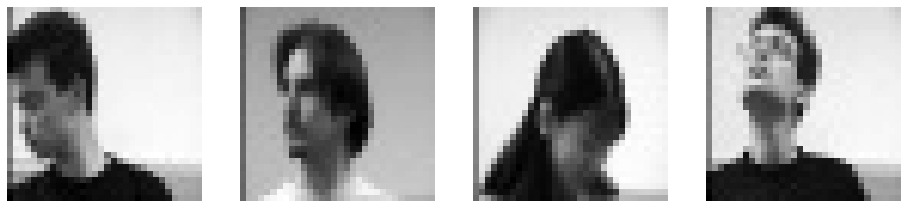

In [10]:
random_index = np.random.choice(100, 4)
rand_data = data.loc[random_index,'filepath']

plt.figure(figsize=(16,4))
for i, filename in enumerate(rand_data):
    im = np.asarray(Image.open(filename))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
    
plt.show()

In [11]:
train_data = pd.merge(raw_data,data, on='filename')

<h3> Data Exploration </h3>

In [12]:
train_data.head()

,filename,person_id,series,tilt,pan,filepath
0,face_790.jpg,5,1,-15,30,modified_data/face_790.jpg
1,face_2445.jpg,5,1,0,-75,modified_data/face_2445.jpg
2,face_2266.jpg,5,2,-15,-60,modified_data/face_2266.jpg
3,face_2713.jpg,5,2,0,-90,modified_data/face_2713.jpg
4,face_2016.jpg,5,2,15,-75,modified_data/face_2016.jpg


In [13]:
train_data.shape

(2325, 6)

In [14]:
train_data['person_id'].unique()

array([ 5,  4,  3, 10, 11,  8,  6,  7,  9, 14, 13, 12, 15])

In [15]:
train_data['series'].unique()

array([1, 2])

In [16]:
train_data['tilt'].unique()

array([-15,   0,  15,  30, -60, -30,  90,  60, -90])

In [17]:
train_data['pan'].unique()

array([ 30, -75, -60, -90,  60, -15, -45, -30,  90,  15,  45,   0,  75])

In [18]:
train_data['person_id'].value_counts()

15    186
13    186
11    186
9     186
7     186
5     186
14    186
12    186
10    186
8     186
6     186
4     186
3      93
Name: person_id, dtype: int64

In [19]:
train_data['series'].value_counts()

2    1209
1    1116
Name: series, dtype: int64

In [20]:
train_data['tilt'].value_counts()

 15    325
-15    325
 60    325
-60    325
 30    325
-30    325
 0     325
 90     25
-90     25
Name: tilt, dtype: int64

In [21]:
train_data['tilt'] = train_data['tilt'].astype(str)

In [22]:
train_data['pan'] = train_data['pan'].astype(str)

In [23]:
# train_data['tilt'] = train_data['tilt'].replace({'15':'Fifteen','-15':'NegativeFifteen','60':'Sixty','-60':'NegativeSixty','30':'Thirty',
#                            '-30':'NegativeThirty','0':'Zero','90':'Ninety','-90':'NegativeNinety'})

In [24]:
train_data['pan'].value_counts()

0      225
-75    175
-90    175
90     175
-15    175
45     175
75     175
60     175
15     175
-45    175
30     175
-60    175
-30    175
Name: pan, dtype: int64

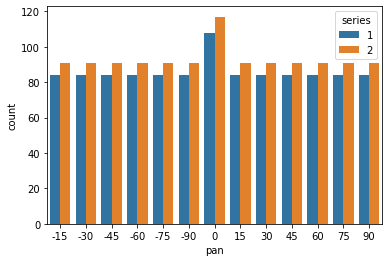

In [25]:
import seaborn as sns
sns.countplot(x='pan', hue='series', data=train_data)

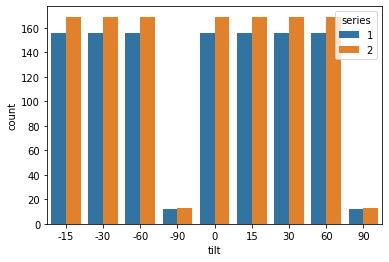

In [26]:
sns.countplot(x='tilt', hue='series', data=train_data)

Creating a subset of the data to classify only the tilt of the head

In [27]:
tilt_train_data = train_data[['filepath','pan']]

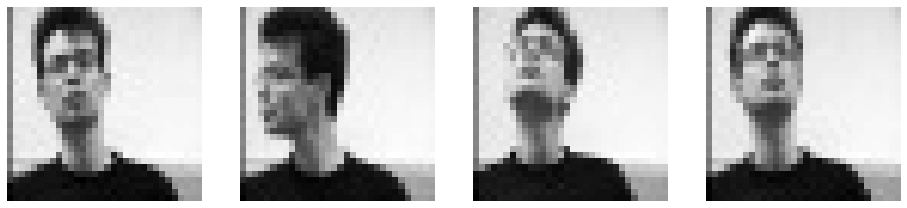

In [28]:
random_index = np.random.choice(100, 4)
rand_data = tilt_train_data.loc[random_index,'filepath']

plt.figure(figsize=(16,4))
for i, filename in enumerate(rand_data):
    im = np.asarray(Image.open(filename))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
    
plt.show()

In [29]:
tilt_train_data.head()

,filepath,pan
0,modified_data/face_790.jpg,30
1,modified_data/face_2445.jpg,-75
2,modified_data/face_2266.jpg,-60
3,modified_data/face_2713.jpg,-90
4,modified_data/face_2016.jpg,-75


## Data Augmentation

In [30]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# dataAugen = ImageDataGenerator(featurewise_center=True,width_shift_range=0.1,height_shift_range=0.1,zoom_range = 0.2,
#                                fill_mode = 'nearest',rescale=1./255, data_format='channels_last')


In [31]:
# data_copy = train_data[['filepath','pan']]
# data_copy['pan'] = data_copy['pan'].astype(str)
# data_copy.head()

In [32]:
# data_90 = data_copy[(data_copy['tilt'] == '90')]
# data_neg_90 = data_copy[(data_copy['tilt'] == '-90')]

In [33]:
# imglist = []
# imglist = data_copy['filepath']
# newlist = []
# for filepath in imglist:

#     img = load_img(filepath)
#     x = img_to_array(img)
#     x = x.reshape((1,)+ x.shape)
#     i=0
#     for batch in dataAugen.flow(x, batch_size=1, save_to_dir='newfacepan', save_prefix='newface_', save_format = 'jpg'):
    
#         i+=1
#         if i>5:
#             break

In [34]:
# image_list = []
# for filepath in glob.glob('newfacepan/*.jpg', recursive=True):
   
#     filename = filepath.split("/")[-1]
#     image_list.append((filepath,'90'))  
                      
# # Create a data frame
# augdata = pd.DataFrame(data=image_list, columns=['filepath','tilt'])

In [35]:
# imglist2 = []
# imglist2 = data_neg_90['filepath']
# for filepath in imglist2:
    
#     img = load_img(filepath)
#     x = img_to_array(img)
#     x = x.reshape((1,)+ x.shape)
#     i=0
#     for batch in dataAugen.flow(x, batch_size=1, save_to_dir='Aug_faceNeg90', save_prefix='newface_', save_format = 'jpg'):
#         i+=1
#         if i>10:
#             break

In [36]:
# image_list = []
# for filepath in glob.glob('Aug_faceNeg90/*.jpg', recursive=True):
   
#     filename = filepath.split("/")[-1]
#     image_list.append((filepath,'-90'))  
                      
# # Create a data frame
# augdata2 = pd.DataFrame(data=image_list, columns=['filepath','tilt'])

In [37]:
# frames = [tilt_train_data, augdata, augdata2]

# tilt_train_data = pd.concat(frames)

In [38]:
# tilt_train_data.head(10)

In [39]:
# tilt_train_data['tilt'].value_counts()

In [40]:
# import shutil

# shutil.rmtree('Aug_faceNeg90')

## Training, Validation and Testing Dataset

The following code is using sklearn library to perform hold-out cross validation and split the dataset into 3 subsets

In [41]:
from sklearn.model_selection import train_test_split

train_data_sample, testing_data = train_test_split(tilt_train_data,test_size = 0.2, random_state=10)
training_data, validation_data = train_test_split(train_data_sample,test_size = 0.2, random_state=10)

In [42]:
training_data.shape

(1488, 2)

In [43]:
labels = training_data.loc[:,'pan']

In [44]:
validation_data.shape

(372, 2)

In [45]:
testing_data.shape

(465, 2)

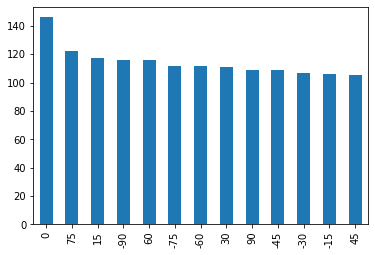

In [46]:
training_data.pan.value_counts().plot(kind='bar')

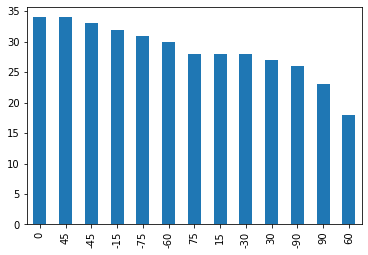

In [47]:
validation_data.pan.value_counts().plot(kind='bar')

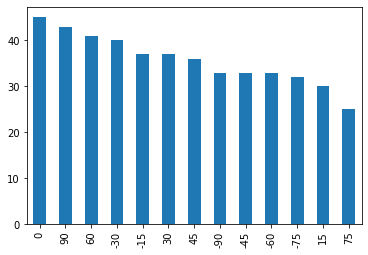

In [48]:
testing_data.pan.value_counts().plot(kind='bar')

## Functions For Model Evaluation & Plotting Results

The following sections define three functions.

1. The First function calculates and returns the average accuracy and the loss for a given image stream.
2. The Second function is used to calculate the accuracy and losses of a trained model
3. The Third function is used to plot the results gained after modelling.

In [49]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return np.mean(loss_hold), np.mean(acc_hold)

In [50]:
def train_model(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [51]:
def plot_results(res):
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

## Model Training & Evaluation

The next block of code:

1. Define the ImageDataGenerator to stream the data into model from dataframes in a specified batch size.
2. Rescale the images to normalize them
3. Define the batch size

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', width_shift_range=0.15,
                                height_shift_range=0.15, zoom_range=0.15,fill_mode="nearest",
                                  featurewise_center = True)


val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./',
    x_col="filepath",
    y_col="pan",
    target_size=(32,32),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./',
    x_col="filepath",
    y_col="pan",
    target_size=(32,32),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testing_data,
    directory='./',
    x_col="filepath",
    y_col="pan",
    target_size=(32,32),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 1488 validated image filenames belonging to 13 classes.
Found 372 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.


In [53]:
# Defining variables with train and validation sample size for later use
N_train_images = 1488
N_val_images = 372

<h2> Convolution Neural Network </h2>

Model 1: Simple LeNet-5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0

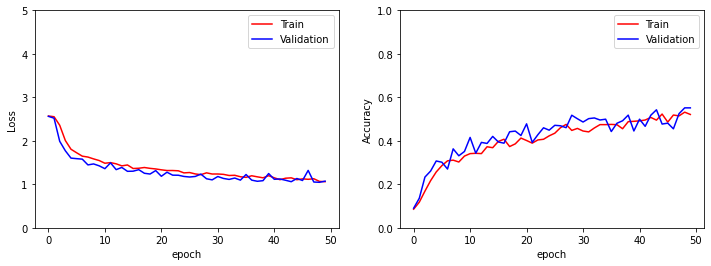

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model1 = Sequential()

# input
model1.add(Input(shape=(32, 32, 3)))

model1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))

model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))

model1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dense(13))
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[categorical_accuracy])
model1.summary()

res = train_model(model1, num_epoch= 50, verbose=1)

plot_results(res)

Model 2: Increased Capacity with Regularization

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_40 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_41 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)       

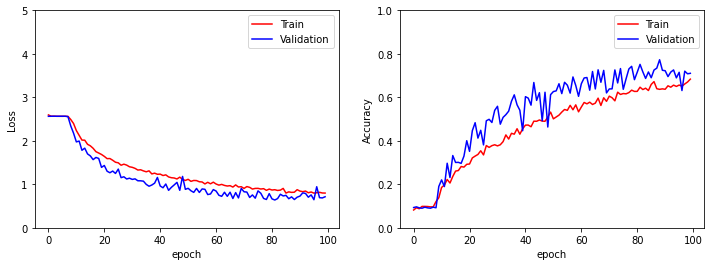

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model2 = Sequential()

# input
model2.add(Input(shape=(32, 32, 3)))

model2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))


model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))


model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(13))
model2.add(Activation('softmax'))


model2.compile(loss='categorical_crossentropy',optimizer='RMSProp',metrics=[categorical_accuracy])
model2.summary()

res = train_model(model2, num_epoch= 100, verbose=1)

plot_results(res)

model4: Adding one more layer in Model2 to increase the depth

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_47 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_48 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)       

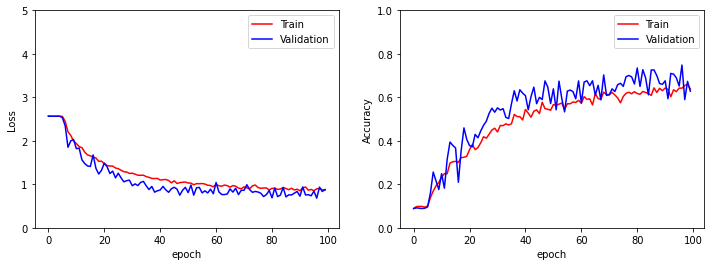

In [69]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model4 = Sequential()

# input
model4.add(Input(shape=(32, 32, 3)))

model4.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


# Conv Layer 1
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))


# Conv Layer 2
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


# Conv Layer 3
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))


# Conv Layer 4
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


# Conv Layer 5
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))



# MLP
model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(13))
model4.add(Activation('softmax'))

model4.compile(loss='categorical_crossentropy',optimizer='RMSProp',metrics=[categorical_accuracy])
model4.summary()

res = train_model(model4, num_epoch= 100, verbose=1)

plot_results(res)

model3: Inspired from VGG-11

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_30 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_31 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)       

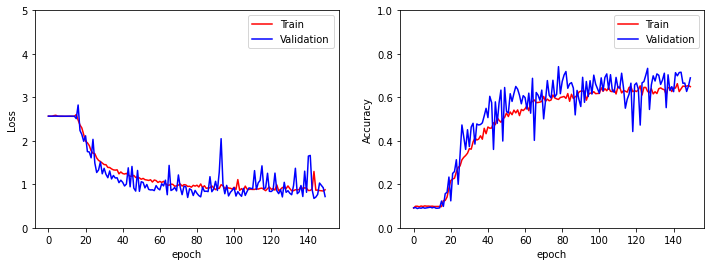

In [62]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model3 = Sequential()

# input
model3.add(Input(shape=(32, 32, 3)))

model3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))
 
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3),padding = 'Same'))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3),padding = 'Same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.12))

# MLP
model3.add(Flatten())
model3.add(Dense(1024))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1024))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(13))
model3.add(Activation('softmax'))

model3.compile(loss='categorical_crossentropy',optimizer='RMSProp',metrics=[categorical_accuracy])
model3.summary()

res = train_model(model3, num_epoch= 150, verbose=1)

plot_results(res)

In [73]:
from sklearn import metrics

from sklearn.metrics import confusion_matrix

predictions = model2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.79      0.89      0.84        37
         -30       0.89      0.78      0.83        40
         -45       0.75      0.82      0.78        33
         -60       0.64      0.91      0.75        33
         -75       0.42      0.62      0.50        32
         -90       0.80      0.12      0.21        33
           0       0.86      0.84      0.85        45
          15       0.69      0.60      0.64        30
          30       0.66      0.68      0.67        37
          45       0.68      0.78      0.73        36
          60       0.75      0.73      0.74        41
          75       0.61      0.56      0.58        25
          90       0.90      0.84      0.87        43

    accuracy                           0.72       465
   macro avg       0.73      0.71      0.69       465
weighted avg       0.74      0.72      0.71       465

[[33  3  0  0  0  0  1  0  0  0  0  0  0]
 [ 3 31

In [86]:
from google.colab import files
uploaded = files.upload()

Saving s3759790_predictions.csv to s3759790_predictions.csv


## Predictions On Test Dataset

In [75]:
testdata = pd.read_csv('test_data.csv')
testdata.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [76]:
predict_data = pd.merge(testdata,data, on='filename')

In [77]:
predict_data.head()


,filename,person_id,series,filepath
0,face_33.jpg,2,1,modified_data/face_33.jpg
1,face_2148.jpg,2,2,modified_data/face_2148.jpg
2,face_2119.jpg,2,1,modified_data/face_2119.jpg
3,face_1262.jpg,2,1,modified_data/face_1262.jpg
4,face_516.jpg,2,2,modified_data/face_516.jpg


In [78]:
predict_data = predict_data[['filepath','filename']]

In [79]:
predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


In [80]:
predict_generator = predict_datagen.flow_from_dataframe(
    dataframe=predict_data,
    directory='./',
    x_col="filepath",
    y_col="filename",
    target_size=(32, 32),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 465 validated image filenames belonging to 465 classes.


In [81]:
predictions = model2.predict_generator(predict_generator,verbose=1)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

15/15 [==============================] - 1s 76ms/step
Prediction shape is (465, 13)


In [82]:
predictedLabels

array([ 6, 12,  7,  6,  1,  1, 12,  2, 10,  1, 12,  6, 10,  1,  9,  5,  6,
        0,  6, 11,  7, 11,  7,  6,  6, 12,  6, 12,  2, 10,  1, 11, 12, 11,
       12, 12,  8,  8,  6,  6, 12,  8,  9,  7,  4,  3,  9,  5,  4, 12,  1,
       11, 12,  6,  3,  5,  7,  6,  6, 12,  6,  4,  4,  1, 12,  2,  2,  3,
       10,  0,  8, 12, 10, 12,  4,  0,  7, 10, 12, 11,  6,  7,  6,  7, 10,
        5, 12,  1,  0,  6,  4,  3,  9,  6,  9,  0,  0,  0, 12,  1,  8,  2,
       10,  6,  2, 12,  6,  6,  6,  2,  9,  4,  7, 10, 12,  7, 12,  9,  9,
       11, 10,  2,  6,  3,  7,  1, 12,  5,  1,  5,  6, 10,  1,  6,  8,  0,
        6,  2,  3,  6,  9,  1, 10, 11, 11,  7,  9,  1, 12, 10,  5, 12, 12,
        1,  5, 10,  7,  3, 10,  6,  8,  6, 10, 10,  6,  4,  6,  7,  7, 11,
        3,  7, 12,  6,  0,  2,  2,  5, 12,  8,  6,  5,  7, 10,  4,  4,  9,
       10,  2,  3,  4, 10,  8,  3,  4,  9,  6, 12,  9, 11, 10,  2,  8, 10,
        9,  0,  6,  0,  1, 10,  1, 12,  6,  6,  4,  5,  4,  9,  7,  0,  4,
        4, 12,  4,  6,  8

In [83]:
for n, i in enumerate(predictedLabels):
    if i == 0:
        predictedLabels[n] = -15
    elif i == 1:
        predictedLabels[n] = -30
    elif i == 2:
        predictedLabels[n] = -45
    elif i == 3:
        predictedLabels[n] = -60
    elif i == 4:
        predictedLabels[n] = -75
    elif i == 5:
        predictedLabels[n] = -90
    elif i == 6:
        predictedLabels[n] = 0
    elif i == 7:
        predictedLabels[n] = 15
    elif i == 8:
        predictedLabels[n] = 30
    elif i == 9:
        predictedLabels[n] = 45
    elif i == 10:
        predictedLabels[n] = 60
    elif i == 11:
        predictedLabels[n] = 75
    else:
        predictedLabels[n] = 90

In [84]:
import pandas as pd
df = pd.DataFrame(predictedLabels, columns=["pan"])
result = pd.concat([predict_data['filename'],df], axis=1, sort=False)

In [85]:
result.head()

,filename,pan
0,face_33.jpg,0
1,face_2148.jpg,90
2,face_2119.jpg,15
3,face_1262.jpg,0
4,face_516.jpg,-30


In [87]:
predict_csv = pd.read_csv('s3759790_predictions.csv') 
pan_pred_data = pd.merge(predict_csv,result, on='filename')

In [88]:
pan_pred_data.head()

,filename,tilt,pan
0,face_33.jpg,90,0
1,face_2148.jpg,60,90
2,face_2119.jpg,0,15
3,face_1262.jpg,15,0
4,face_516.jpg,-15,-30


In [89]:
pan_pred_data.to_csv('s3759790_predictions.csv', index=False)